<a href="https://colab.research.google.com/github/zyf2021/-/blob/main/wine_segmentation_v_0_0_5_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Что тут происходит
> Есть выделение в классы и One-hot кодирование
> Нужны метрики
> Все предыдущие версии WINE_SEGMENTATION_V_0_0_*
> Сейчас будет WINE_SEGMENTATION_V_0_0_5_Unet
# Продолжаем мучить нашу сегментацию.
В этот раз сделаем собственную модель Unet для обучения.
- [X] Не работает функция display_random_image в 5 пункте.
- [x] Не нравится, что rgb_to_label делает разные цвета для одних и тех же классов на разных масках. Где-то виноградник чисто белый, где-то серый... Мне показалаось. Все правильно, я проверила в матрице. Это графики плохо отрисовывают...
- [ ] Unet работает отвратительно, требует много памяти. В зависимости от видеокарты или 5 или 15 эпох. Все.
- [ ] Все полученнные результаты (графики и модели, сохранить, описать)
- [ ] Для нормальной оценки результатов доабвить надо Dice и IOU
- [ ] Подумать над тем, чтобы заменить модель на ResNet, MaskRCNN или что-то другое из библиотеки torch


# Импорт библиотек

In [ ]:
!pip install torchmetrics

In [ ]:
!pip install torchinfo torchview

  Obtaining dependency information for torchinfo from https://files.pythonhosted.org/packages/72/25/973bd6128381951b23cdcd8a9870c6dcfc5606cb864df8eabd82e529f9c1/torchinfo-1.8.0-py3-none-any.whl.metadata
  Obtaining dependency information for torchview from https://files.pythonhosted.org/packages/84/a8/09cccd76a6ac4d021354bafbb9b330fd1763b5cace99aa6af47b8d27dc87/torchview-0.2.6-py3-none-any.whl.metadata


In [ ]:
!pip install albumentations

  Obtaining dependency information for albumentations from https://files.pythonhosted.org/packages/95/78/046ba720532436716050c27fd71cb838d14a2dc4b676b7a0883e1e3deebe/albumentations-1.4.1-py3-none-any.whl.metadata
  Obtaining dependency information for numpy>=1.24.4 from https://files.pythonhosted.org/packages/3a/d0/edc009c27b406c4f9cbc79274d6e46d634d139075492ad055e3d68445925/numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
  Obtaining dependency information for scikit-image>=0.21.0 from https://files.pythonhosted.org/packages/d4/34/e27bf2bfe7b52b884b49bd71ea91ff81e4737246735ee5ea383314c31876/scikit_image-0.22.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for typing-extensions>=4.9.0 from https://files.pythonhosted.org/packages/f9/de/dc04a3ea60b22624b51c703a84bbe0184abcd1d0b9bc8074b5d6b7ab90bb/typing_extensions-4.10.0-

In [ ]:
!pip install graphviz

  Obtaining dependency information for graphviz from https://files.pythonhosted.org/packages/de/5e/fcbb22c68208d39edff467809d06c9d81d7d27426460ebc598e55130c1aa/graphviz-0.20.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 773.3 kB/s eta 0:00:00B/s eta 0:00:01


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import random
import json
import matplotlib.pyplot as plt

import cv2
from sklearn.model_selection import train_test_split

from tqdm.auto import tqdm
import gc
import os
import re
import shutil

#import albumentations as A
#from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
import torchmetrics

import albumentations as A
from albumentations.pytorch import ToTensorV2

from torchinfo import summary
from torchview import draw_graph

import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

from PIL import Image

import glob

In [ ]:
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

torch:  2.2 ; cuda:  cu118


# Установка параметров нашей модели

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Создадим пути к папке с изображениями
#TRAIN_DATA_PATH = 'D:/SNO/WINEYARD/DIFF_VAR/tynshun_wineyard_coco_panoptic/export_coco-panoptic_tynshun_wineyard_v.0.1.json'

ANNOTATION_DATA_PATH = '/content/drive/MyDrive/COCO_PANOPTIC/export_coco-panoptic_tynshun_wineyard_v.0.1.json'
#DATA_DIR = 'D:/SNO/WINEYARD/DIFF_VAR/tynshun_wineyard_coco_panoptic/v.0.1/'

# Создадим пути к папкам train, val, test
TRAIN_DIR = '/content/drive/MyDrive/COCO_PANOPTIC/TRAIN/'
VAL_DIR = '/content/drive/MyDrive/COCO_PANOPTIC/VAL/'
TEST_DIR = '/content/drive/MyDrive/COCO_PANOPTIC/TEST/'

# Создадим пути к папке с изображениями
#TRAIN_DATA_PATH = 'D:/SNO/WINEYARD/DIFF_VAR/tynshun_wineyard_coco_panoptic/export_coco-panoptic_tynshun_wineyard_v.0.1.json'

# ANNOTATION_DATA_PATH = '/media/ary/Новый том/SNO/WINEYARD/DIFF_VAR/tynshun_wineyard_coco_panoptic/export_coco-panoptic_tynshun_wineyard_v.0.1.json'
# DATA_DIR = 'D/media/ary/Новый том/SNO/WINEYARD/DIFF_VAR/tynshun_wineyard_coco_panoptic/v.0.1/'

# Создадим пути к папкам train, val, test
# TRAIN_DIR = '/media/ary/Новый том/SNO/WINEYARD/DIFF_VAR/COCO_PANOPTIC/TRAIN/' # /media/ary/Новый том/SNO/WINEYARD/DIFF_VAR
# VAL_DIR = '/media/ary/Новый том/SNO/WINEYARD/DIFF_VAR/COCO_PANOPTIC/VAL/'
# TEST_DIR = '/media/ary/Новый том/SNO/WINEYARD/DIFF_VAR/COCO_PANOPTIC/TEST/'

# Выберем устройство для вычислений
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Выставим гиперпараметры
EPOCHS = 10        # number of epochs
LR = 0.001         # Learning rate
IMG_SIZE = 64     # Size of image 320
BATCH_SIZE = 2    # Batch size
NUM_EPOCHS = 5

# 2. Вспомогательные функции

## 2.1. Загрузка JSON-файла аннотаций COCO

In [ ]:
def get_df_images_masks(path_to_coco, path_to_dir):
    with open(path_to_coco, 'r') as f:
        coco_data = json.load(f)
        df_images = pd.DataFrame(coco_data['images'])
        df_images['file_name'] = df_images['file_name'].apply(lambda x: path_to_dir + x)
        df_images.rename(columns={'id': 'image_id'}, inplace=True)
        df_annotations = pd.DataFrame(coco_data['annotations'])
        df_annotations['file_name'] = df_annotations['file_name'].apply(lambda x: path_to_dir + x)
        # Склеивание DataFrame по столбцу 'id'
        merged_df = pd.merge(df_images, df_annotations, on='image_id')
        merged_df.rename(columns={'file_name_x': 'images'}, inplace=True)
        merged_df.rename(columns={'file_name_y': 'masks'}, inplace=True)
        return merged_df

## 2.2. Функция по поиску классов сегментации и словаря цветов сегментации
## **Гипотетически надо будет поменять на tuple**

In [ ]:
def find_classes(directory: str): # указать возвращаемый тип данных
    # дописать многострочный комментарий
    '''
    Функция используется в самодельном классе Dataset
    '''
    with open(directory, 'r') as f:
        data_json = json.load(f)

    type(data_json['categories'])


    classes = ['__background__']
    colors = [[0, 0, 0]]

    colors_idx = dict()
    colors_idx['__background__'] = [0, 0, 0]

    classes_idx = dict()
    classes_idx['__background__'] = 0

    for el in data_json['categories']:
        classes.append(el['name'])
        colors.append(el['color'])
    classes_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    for i in range(len(classes)):
        colors_idx[classes[i]] = colors[i]

    return classes, classes_idx, colors_idx

## 2.3. Функция для вывода 5 случайных изображений

In [ ]:
def generate_sample_images(sample):
    imgs = sample.images

    _, ax = plt.subplots(1, 5, figsize=(15,3))
    ax = ax.flatten()

    for i, image in enumerate(imgs):
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax[i].set_title("IMAGE")
        ax[i].imshow(image)

def generate_sample_masks(sample):
    masks = sample.masks

    _, ax = plt.subplots(1, 5, figsize=(15,3))
    ax = ax.flatten()

    for i, mask in enumerate(masks):
        mask = cv2.imread(mask, cv2.COLOR_BGR2RGB) / 255.0 #перевод в серую шкалу и нормализация! ВАУ!

        ax[i].set_title("GROUND TRUTH")
        ax[i].imshow(mask, cmap='gray')

## 2.4. Функция для отображения

In [ ]:
def show_image_from_df(image_path):
    image = cv2.imread(image_path)
  # Отображение изображения
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

## 2.5 Получим список файлов в папке

In [ ]:
def get_files_list(folder_path):
    return os.listdir(folder_path)

## 2.6 Получим список изображений и масок в папке

In [ ]:
def get_image_and_mask_lists(file_list):
    # Получение пути изображения и маски
    image_list = []
    mask_list = []
    pattern_image = re.compile(r'frame_\d+\.jpg')
    pattern_mask = re.compile(r'frame_\d+_label_ground-truth_coco-panoptic\.png')
    for file_name in file_list:
        if pattern_image.match(file_name):
            image_list.append(file_name)
        if pattern_mask.match(file_name):
            mask_list.append(file_name)
    image_list.sort()
    mask_list.sort()
    return image_list, mask_list

## 2.7. Получить список случайных изображений

In [ ]:
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    if seed:
        random.seed(seed)

    random_array = np.random.randint(0, len(dataset), n)
    print(random_array)
    plt.figure(figsize=(16, 8))
    for i, idx in enumerate(random_array):
        image, mask = dataset[idx]
        plt.subplot(2, 5, i+1)
        plt.imshow(np.transpose(image, (1, 2, 0)))
        plt.axis('off')
        plt.title("IMAGE")

        plt.subplot(2, 5, i+6)
        plt.imshow(np.transpose(mask, (1, 2, 0)), cmap='gray')
        plt.axis('off')
        plt.title("GROUND TRUTH")
    plt.tight_layout()
    plt.show()


# 3. Исследуем наши данные

In [ ]:
#df = get_df_images_masks(ANNOTATION_DATA_PATH, DATA_DIR)
#df.head()
#print(df.shape)

In [ ]:
#sample = df.iloc[np.random.randint(0, df.shape[0], size=5)]# выберем 5 случайных индексов из нашего df
#generate_sample_images(sample)
#generate_sample_masks(sample)

# 4. Data Augmentation

In [ ]:
aug_transform = A.Compose([
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=(45, 225), interpolation=cv2.INTER_NEAREST, p=0.8),
    A.OneOf([
        A.GridDistortion(interpolation=cv2.INTER_NEAREST, p=0.5),
        A.OpticalDistortion(distort_limit=1, shift_limit=0.5, interpolation=cv2.INTER_NEAREST, p=0.5)
    ], p=0.8),
    A.RandomGamma(p=0.5),
    A.RandomBrightnessContrast(p=1.0)
], p=1.0)

test_aug_transform = A.Compose([
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
], p=1.0)

# 5. Работа с Dataset

## 5.2. class MultiClassDataset(Dataset):

Создадим свой класс для датасета. На этот раз для многоклассовой сегментации

In [ ]:
class MultiClassDataset(Dataset):
    """
        dataset_dir: str - TRAIN_DATA, VAL_DATA, TEST_DATA
    """
    def __init__(self,
                 dataset_dir: str, # TRAIN_DIR VAL_DIR TEST_DIR
                 annotation_dir: str,
                 #file_list: list,
                 #image_list=None,
                 #mask_list:=None,
                 transform=None):
        self.dataset_dir = dataset_dir
        self.file_list = os.listdir(dataset_dir)
        self.image_list, self.mask_list = get_image_and_mask_lists(os.listdir(dataset_dir))
        #self.image_list = image_list
        #self.mask_list = mask_list
        self.classes, self.class_to_idx, self.colors_to_idx = find_classes(annotation_dir)
        self.colormap = self.colors_to_idx.values()
        self.transform = transform

    def rgbmask_to_label(self,
                         rgb_mask: np.ndarray,
                         colormap: list):
        """
        Converts a single RGB masks into onehot encoding masks and finally
        creates a single channel class index label.
        Parameters:
            rgb_mask: A array containing the mask in RGB format and shape (HWC).
            colormap: A list with all the RGB colors for every single class
                      in proper sequence.
        Returns:
            output: A array that is converted from RGB mask to label encoded in
                    shape (H x W).
        """
        # A array to fill the output later.
        output = np.zeros(rgb_mask.shape[:2])

        for label, color in enumerate(colormap):
            if label < len(colormap):
                # Matching the mask with the colormap
                # Then replacing with classes index
                output[np.all(np.equal(rgb_mask, color), axis=-1)] = label

        return output

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):

        image_path = os.path.join(self.dataset_dir, self.image_list[index])
        mask_path = os.path.join(self.dataset_dir, self.mask_list[index])

        # Чтение файлов изображения и маски в формате RGB
        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2RGB)


        # Преобразование изображения и масок с использованием аугментации
        if self.transform is not None:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']

        mask = (mask.detach().numpy() if type(mask) == torch.Tensor else mask)
        mask = self.rgbmask_to_label(rgb_mask=mask, colormap=self.colormap)
        mask = torch.from_numpy(mask).type(torch.LongTensor)

        image = torch.from_numpy(image).permute(2,0,1)

        return image, mask

In [ ]:
dataset = MultiClassDataset(TRAIN_DIR, ANNOTATION_DATA_PATH, transform = aug_transform)

In [ ]:
train_dataset = MultiClassDataset(TRAIN_DIR, ANNOTATION_DATA_PATH, transform = aug_transform)
val_dataset = MultiClassDataset(VAL_DIR, ANNOTATION_DATA_PATH, transform = aug_transform)
test_dataset = MultiClassDataset(TEST_DIR, ANNOTATION_DATA_PATH, transform = test_aug_transform)

## 5.3. Display sample random images

Size of the dataset: 210
Shape of Image: torch.Size([3, 64, 64]) and mask: torch.Size([64, 64])
Classes in the mask images: [0 1]

Plotting the data:


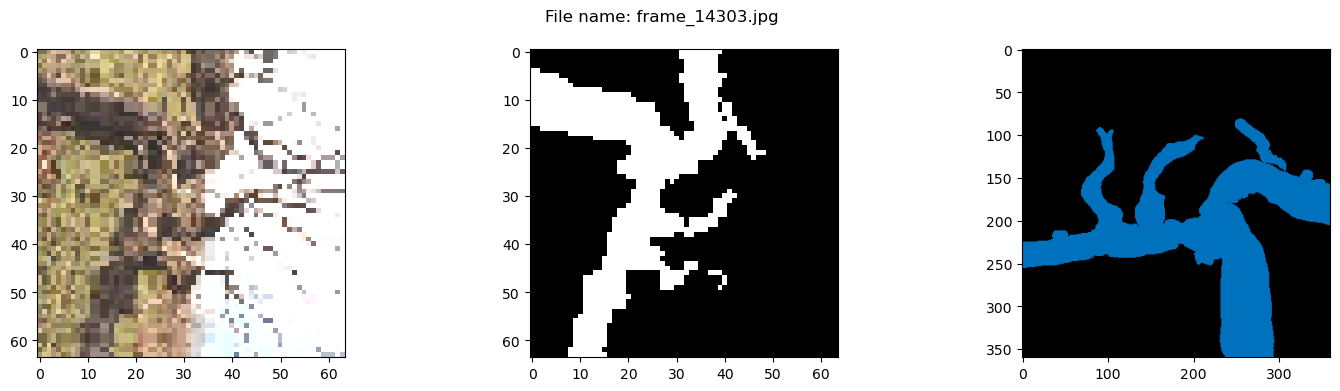

In [ ]:
rand_num = np.random.randint(len(dataset))
image, mask = dataset[rand_num]

print(f'Size of the dataset: {len(dataset)}')
print(f'Shape of Image: {image.shape} and mask: {mask.shape}')
print(f'Classes in the mask images: {np.unique(mask)}')
print('\nPlotting the data:')

filename = dataset.image_list[rand_num]
maskname = dataset.mask_list[rand_num]
plt.figure(figsize=(18, 4))
plt.suptitle(f'File name: {filename}')
plt.subplot(131)
plt.imshow(image.permute(1,2,0))
plt.subplot(132)
plt.imshow(mask, 'gray')
plt.subplot(133)
plt.imshow(plt.imread(os.path.join(dataset.dataset_dir, maskname)))

# 6. Создадим DataLoader

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

print(f"Общее количество батчей в Train Loader: {len(train_dataloader)}")
print(f"Общее количество батчей в in Val Loader: {len(val_dataloader)}")
print(f"Общее количество батчей в in Test Loader: {len(test_dataloader)}")

Общее количество батчей в Train Loader: 105
Общее количество батчей в in Val Loader: 30
Общее количество батчей в in Test Loader: 15


In [ ]:
for image, mask in train_dataloader:
    print(f"Size of one batch of images: {image.shape}")
    print(f"Size of one batch of masks: {mask.shape}")
    break

Size of one batch of images: torch.Size([2, 3, 64, 64])
Size of one batch of masks: torch.Size([2, 64, 64])


# 7. Создадим нашу Unet модель

Модель имеет такое же представление, как указано в названии. Модель U-образной формы. Причина U-образной формы кроется в работе модели, модель начинается с левой стороны и движется к центру, сжимая данные и сохраняя только особенности изображения, эта часть модели даже называется кодировщиком. Затем данные перемещаются в правый угол, где данные реконструируются со всеми известными признаками и представляются в виде маски, эта часть модели называется декодером.

![UNet++ architecture](https://pic.imgdb.cn/item/60dac54e5132923bf81d4a25.jpg)

I will now create the Segmentation model using the Unet++ architecture. The parameters used for the model are:
- **Efficient Net** is used as the encoder model
- Weights used are of **Imagenet**
- Input channels are 3 due to **RGB** images

In the forward method I defined the loss functions. DiceLoss and Binary Cross Entropy are used as loss functions for this task.

[Dice loss](https://serp.ai/dice-loss/#:~:text=Dice%20Loss%20is%20an%20important,true%20segmentation%20of%20an%20image.) is a metric commonly used to evaluate the performance of machine learning models in image segmentation tasks. It is a measure of the dissimilarity between the predicted segmentation (mask) and the true segmentation of an image.

### DoubleConvLayer

In [ ]:
class DoubleConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            # First convolution layer
            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(inplace=True),

            # Second convolution layer
            nn.Conv2d(in_channels=out_channels,
                      out_channels=out_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

## 7.1. Напишем Encoder
Путь кодировщика принимает данные изображения и постепенно начинает выполнять метод понижающей дискретизации, это выполняется с помощью свертки и объединения слоев.

Если вы посмотрите на архитектуру, то можете заметить закономерность: все слои понижающей выборки имеют два слоя свертки. мы создадим класс torch.nn.Module, имеющий два слоя свертки. При использовании слоев свертки мы не будем изменять пространственное измерение, применяя отступы и вместе со сверткой пакетную нормализацию для смещения и активацию ReLU, чтобы сделать его нелинейным.

### DownSampling

In [ ]:
class DownSampling(nn.Module):
    """
    This class implements the downsampling part of the architecture.
    If you check the architecture dig., the left path displays the red arrow
    indicating the downsampled layer using the max pool.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.down_sample = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Initializing the layer using the double convolution layer class
            DoubleConvLayer(in_channels=in_channels,
                            out_channels=out_channels)
        )

    def forward(self, x):
        return self.down_sample(x)

> При использовании понижающей дискретизации модель изучает особенности изображения, но также теряет пространственную информацию. Итак, чтобы вернуть потерянные данные, нам нужно выполнить декодирование после этого.

## 7.2. Decoder(Expansion Path)

### UpSampling

In [ ]:
class UpSampling(nn.Module):
    """
    This class implements the upsampling part of the architecture.
    If you check the architecture dig., the right path displays the green arrow
    indicating the upsampled layer.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Using Transposed convolution for upsampling
        self.up_sample = nn.ConvTranspose2d(in_channels=in_channels,
                                            out_channels=out_channels,
                                            kernel_size=2,
                                            stride=2)
        self.double_conv = DoubleConvLayer(in_channels=in_channels,
                                           out_channels=out_channels)

    def forward(self, x1, x2):
        """
        x1 is the output tensor of the previous layer, which will be upsampled.
        x2 is the skip connection tensor that was generated during
        downsampling.
        """
        x1 = self.up_sample(x1)

        # Correcting the shape after upsampling
        if x1.shape != x2.shape:
            x1 = TF.resize(img=x1, size=x2.shape[2:], antialias=True)

        x = torch.cat((x2, x1), 1)
        return self.double_conv(x)

## 7.3. Complete U-Net Architecture

Теперь, когда мы создали как понижающую, так и повышающую дискретизацию модели, мы можем завершить модель, собрав кусочки и завершив головоломку.

Мы начинаем с понижающей дискретизации для 4 слоев (включая входной слой), каждый слой увеличивает объекты в 2 раза и уменьшает пространственный размер в 2 раза.
Затем мы создаем нижний слой свертки, который предназначен только для передачи данных на этап повышения дискретизации.
Как только мы получаем данные нижнего уровня, он переходит к повышению дискретизации, а также принимает данные о пропущенном соединении из понижающей дискретизации и перемещается до 4 уровней.
Наконец, достигая последних слоев, данные проходят через последний слой, где данные объектов свернуты в соответствии с общим количеством присутствующих классов и формируют изображение в соответствии с исходной формой.

In [ ]:
class UnetModel(nn.Module):
    def __init__(self,
                 n_classes: int,
                 in_channels=3):
        super().__init__()
        features = [64, 128, 256]
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.skip_connection = []

        # The input layer of the model [BCHW]
        # Eg. input tensor shape: [1, 3, 572, 572]
        self.encoder.append(DoubleConvLayer(in_channels=in_channels,
                                            out_channels=features[0]))
        # Eg. output tensor shape: [1, 64, 572, 572]

        # A 3 layer downsampling
        # Eg. input tensor shape: [1, 64, 572, 572]
        for feature in features:
            self.encoder.append(DownSampling(in_channels=feature,
                                             out_channels=feature * 2))
        # Eg. output tensor shape: [1, 512, 71, 71]

        # Bottom layer of the UNet Model
        # Eg. input tensor shape: [1, 512, 71, 71]
        self.bottom_layer = DownSampling(in_channels=features[-1]*2,
                                         out_channels=features[-1]*4)
        # Eg. output tensor shape: [1, 1024, 35, 35]

        # A 3-layer upsampling
        # Eg. input tensor shape: [1, 1024, 35, 35]
        for feature in reversed(features):
            self.decoder.append(UpSampling(in_channels=feature * 4,
                                           out_channels=feature * 2))
        # Eg. output tensor shape: [1, 128, 286, 286]

        # Upsampling before the final layer
        # Eg. input tensor shape: [1, 128, 286, 286]
        self.decoder.append(UpSampling(in_channels=features[1],
                                       out_channels=features[0]))
        # Eg. output tensor shape: [1, 64, 572, 572]

        # Final layer of the model, giving the predicted mask
        # Eg. input tensor shape: [1, 64, 572, 572]
        self.final_layer = nn.Conv2d(in_channels=features[0],
                                     out_channels=n_classes,
                                     kernel_size=1)
        # Eg. output tensor shape: [1, n_classes, 572, 572]

    def forward(self, x):
        for encode in self.encoder:
            x = encode(x)
            # Appending all the downsampled output for skip connection
            self.skip_connection.append(x)

        x = self.bottom_layer(x)

        for decode, skip in zip(self.decoder,
                                reversed(self.skip_connection)):
            # Upsampling using the skip connection that was collected durning downsampling
            x = decode(x, skip)

        return self.final_layer(x)

## 7.4. Проверка работы модели

In [ ]:
# Performing a unit test to check whether the model works or not
#x = torch.randn((3, 3, 224, 224))
#model = UnetModel(n_classes=3, in_channels=3)
#output = model(x)
#assert x.shape[2:] == output.shape[2:]
#print(f'Input shape: {x.shape} and output shape: {output.shape}')

### Summary of the model

In [ ]:
summary(model=UnetModel(n_classes=3),
        input_size=(1, 3, 64, 64),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

/home/ary/anaconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
UnetModel (UnetModel)                              [1, 3, 64, 64]       [1, 3, 64, 64]       --                   True
├─ModuleList (encoder)                             --                   --                   --                   True
│    └─DoubleConvLayer (0)                         [1, 3, 64, 64]       [1, 64, 64, 64]      --                   True
│    │    └─Sequential (double_conv)               [1, 3, 64, 64]       [1, 64, 64, 64]      38,848               True
│    └─DownSampling (1)                            [1, 64, 64, 64]      [1, 128, 32, 32]     --                   True
│    │    └─Sequential (down_sample)               [1, 64, 64, 64]      [1, 128, 32, 32]     221,696              True
│    └─DownSampling (2)                            [1, 128, 32, 32]     [1, 256, 16, 16]     --                   True
│    │    └─Sequential (down_sample)       

In [ ]:
# Visualizing the model
#model_graph = draw_graph(UnetModel(5), input_size=(1,3,224,224), expand_nested=True)
#model_graph.visual_graph

# 9. Create Train and Validation Function
# Writing the training and testing step function

### calculate_accuracy

In [ ]:
# Creating a function to calculate accuracy and DICE metrics while training the model
def calculate_accuracy(pred: torch.Tensor,
                       target: torch.Tensor):
    """
    Calculate multi-class accuracy for the provided tensor while training the
    model
    Parameters:
        pred (torch.Tensor): Raw logits produced by the model, the shape of
                             the tensor needs to be (B,C,H,W).
        target (torch.Tensor): A ground truth tensor, that is label encoded of
                               shape (B,H,W).
    Returns: Accuracy score
    """
    assert len(pred.shape) == 4 and len(target.shape) == 3
    pred = nn.Softmax2d()(pred).argmax(1).int()
    target = target.int()
    return ((pred == target).sum() / torch.numel(target)).item()

### calculate_iou_dice

In [ ]:
def calculate_iou_dice(pred: torch.Tensor,
                       target: torch.Tensor,
                       n_classes: int):
    """
    Calculate multi-class DICE and IoU score for the provided tensor while
    training the model
    Parameters:
        pred (torch.Tensor): Raw logits produced by the model, the shape of
                             the tensor needs to be (B,C,H,W).
        target (torch.Tensor): A ground truth tensor, that is label encoded of
                               shape (B,H,W).
        n_classes (int): Total number of classes
    Returns:
        iou_array (numpy.ndarray): A array with iou score for all the classes.
        iou_mean (float): A average iou score.
        dice_array (numpy.ndarray): A array with dice score for all the classes.
        dice_mean (float): A average dice score.
    """
    assert len(pred.shape) == 4 and len(target.shape) == 3
    assert pred.shape[1] == n_classes
    dice_array = []
    iou_array = []

    # Getting the predicted labels for every pixel
    # Flattening both the predicted and groundtruth tensor
    pred = nn.Softmax2d()(pred).argmax(dim=1).view(-1)
    target = target.view(-1)

    # Looping through the data for each class and
    # calculating the DICE and Iou score
    for class_idx in range(n_classes):

        # Creating a tensor for matching classes
        pred_inds = pred == class_idx
        target_inds = target == class_idx

        # Calculating the IoU score
        intersection = (pred_inds[target_inds]).long().sum().item()
        union = pred_inds.long().sum().item() \
                + target_inds.long().sum().item() - intersection

        # Stopping the zero error for division
        if union == 0:
            iou = 0
            iou_array.append(iou)
            dice_array.append(iou)
        else:
            iou = intersection / union
            iou_array.append(iou)

            # Calculating the dice score
            dice = (2 * iou) / (iou + 1)
            dice_array.append(dice)

    # Getting the average of both the scores
    iou_mean = np.mean(iou_array)
    dice_mean = np.mean(dice_array)

    return (np.array(iou_array), iou_mean,
            np.array(dice_array), dice_mean)

### train_step

In [ ]:
# Writing the training step function
def train_step(model, dataloader, loss_fn, optimizer, num_classes, device):

    model.train()

    train_loss = 0
    #train_iou = torchmetrics.IoU(num_classes=num_classes)
    #train_dice = torchmetrics.Dice(num_classes=num_classes)
    train_accuracy = 0 # torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device)



    for batch, (images, masks) in enumerate(dataloader):
        images = images.float().to(device=device)
        masks = masks.float().to(device=device).long()

        # forward pass...
        pred_masks = model(images)

        # calculate loss
        loss = loss_fn(pred_masks, masks)
        train_loss += loss.item()

        # optimizer zero grad
        optimizer.zero_grad()

        # loss backward
        loss.backward()

        # optimizer step
        optimizer.step()

        # Update metrics
        pred_labels = torch.argmax(pred_masks, dim=1)
        train_accuracy += calculate_accuracy(pred=pred_masks, target=masks)

        #train_iou.update(pred_labels, masks)
        #train_dice.update(pred_labels, masks)
        #train_accuracy.update(pred_labels, masks)

    train_loss = train_loss / len(dataloader)
    train_accuracy /= len(dataloader)
    #train_iou_mean /= len(dataloader)
    #train_dice_mean /= len(dataloader)
    torch.cuda.empty_cache()
    gc.collect()

    return (train_loss, train_accuracy) #, train_iou_mean, train_dice_mean)

### test_step

In [ ]:
# Writing the testing step function
def test_step(model, dataloader, loss_fn, num_classes, device):

    model.eval()

    test_loss = 0
    test_accuracy = 0
    #test_iou = torchmetrics.IoU(num_classes=num_classes)
    #test_dice = torchmetrics.Dice(num_classes=num_classes)
    #test_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device)
    with torch.inference_mode():
        for batch, (images, masks) in enumerate(dataloader):
            images = images.float().to(device=device)
            masks = masks.float().to(device=device).long()

            # forward pass...
            pred_masks = model(images)

            # calculate loss
            loss = loss_fn(pred_masks, masks)
            test_loss += loss.item()

            # Update IoU metric
            pred_labels = torch.argmax(pred_masks, dim=1)
            test_accuracy += calculate_accuracy(pred=pred_masks, target=masks)
            #test_iou.update(pred_labels, masks)
            #test_dice.update(pred_labels, masks)
            #test_accuracy.update(pred_labels, masks)

    #
    test_loss = test_loss / len(dataloader)
    test_accuracy /= len(dataloader)
    #test_iou_mean /= len(dataloader)
    #test_dice_mean /= len(dataloader)
    torch.cuda.empty_cache()
    gc.collect()

    return (test_loss, test_accuracy) #, test_iou_mean, test_dice_mean)

### Function to train the model using the above train and test steps

In [ ]:
def model_training(model,
                   train_dataloader,
                   test_dataloader,
                   loss_fn,
                   optimizer,
                   device,
                   num_classes: int = 3,
                   epochs: int = 5):

    # Создадим словарь для хранения всех наших метрик
    results = {'train_loss': [],
               'train_acc': [],
               #'train_iou_mean': [],
               #'train_dice_mean': [],

               'test_loss': [],
               'test_acc': [],
               #'test_iou_mean': [],
               #'test_dice_mean': []
              }

    # Train and eval/test loop
    for epoch in tqdm(range(epochs)):
        # Model training
        (train_loss, train_acc
         #, train_iou_mean, train_dice_mean
        ) = train_step(model=model,
                       dataloader=train_dataloader,
                       loss_fn=loss_fn,
                       optimizer=optimizer,
                       num_classes=num_classes,
                       device=device)

        # Model testing
        (test_loss, test_acc
        #, test_iou_mean, test_dice_mean
        ) = test_step(model=model,
                    dataloader=test_dataloader,
                    loss_fn=loss_fn,
                    num_classes=num_classes,
                    device=device)

        print(f'Epoch: {epoch + 1} | Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc}|')
        print(f'Epoch: {epoch + 1} | Test Loss: {test_loss:.3f}, Test Accuracy: {test_acc}|')

        # Storing every epoch result in the the resultdict.
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        # results['train_iou_mean'].append(train_iou_mean)
        #results['train_dice_mean'].append(train_dice_mean)

        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)
        # results['test_iou_mean'].append(test_iou_mean)
        # results['test_dice_mean'].append(test_dice_mean)

        torch.cuda.empty_cache()
        gc.collect()

    return results

Before training the model make sure that your GPU is running because it would take eternity to train the model on a CPU.

# Model Training

In [ ]:
torch.cuda.empty_cache()
gc.collect()

76

In [ ]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [ ]:
# Set random seeds
#torch.manual_seed(42)
#torch.cuda.manual_seed(42)

model = UnetModel(n_classes=3 ).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model
model_results = model_training(model=model,
                      train_dataloader=train_dataloader,
                      test_dataloader=val_dataloader,
                      loss_fn=loss_fn,
                      optimizer=optimizer,
                      device = DEVICE,
                      num_classes = 3,
                      epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 0.491, Train Accuracy: 0.8580229259672619|
Epoch: 1 | Test Loss: 0.351, Test Accuracy: 0.8845052083333333|
Epoch: 2 | Train Loss: 0.316, Train Accuracy: 0.8895159040178572|
Epoch: 2 | Test Loss: 0.293, Test Accuracy: 0.9032633463541667|
Epoch: 3 | Train Loss: 0.299, Train Accuracy: 0.8948451450892857|
Epoch: 3 | Test Loss: 0.276, Test Accuracy: 0.9066121419270833|
Epoch: 4 | Train Loss: 0.288, Train Accuracy: 0.8974028087797619|
Epoch: 4 | Test Loss: 0.317, Test Accuracy: 0.90228271484375|
Epoch: 5 | Train Loss: 0.286, Train Accuracy: 0.8960507347470238|
Epoch: 5 | Test Loss: 0.341, Test Accuracy: 0.89776611328125|
Total training time: 25.037 seconds


In [ ]:
gc.collect()

18

In [ ]:
model_results['train_acc'][0]

0.8580229259672619

In only 10 epochs the model reduced the validation loss to close to 0.2 which is very good. THis shows the power of the Unet architecture on Image segmentation preoblems. Now let's see how our model predictions look in comparison to the original masks.

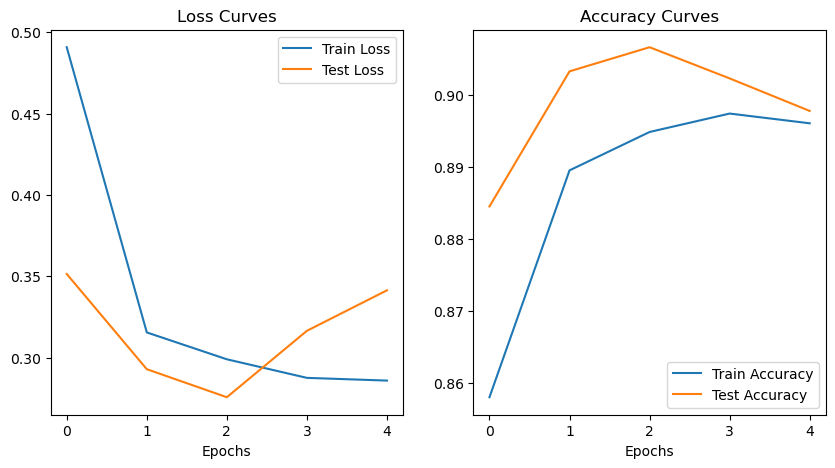

In [ ]:
def plot_performance_metrics(model_result: dict):
    """
    Plot the performance metrics from training and testing the model.
    Parameters:
        model_result: A dict containing all the metrics.
    """

    '''
    # Plotting loss curves
    plt.subplot(2, 2, 1)
    plt.plot(epochs, model_result['train_loss'], label='Train Loss')
    plt.plot(epochs, model_result['test_loss'], label='Test Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.legend()

    # Plotting loss curves
    plt.subplot(2, 2, 2)
    plt.plot(epochs, model_result['train_acc'], label='Train Accuracy')
    plt.plot(epochs, model_result['test_acc'], label='Test Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.legend()

    # Plotting loss curves
    plt.subplot(2, 2, 3)
    plt.plot(epochs, model_result['train_iou_mean'], label='Train IoU')
    plt.plot(epochs, model_result['test_iou_mean'], label='Test IoU')
    plt.title('Mean IoU Curves')
    plt.xlabel('Epochs')
    plt.legend()

    # Plotting loss curves
    plt.subplot(2, 2, 4)
    plt.plot(epochs, model_result['train_dice_mean'], label='Train DICE')
    plt.plot(epochs, model_result['test_dice_mean'], label='Test DICE')
    plt.title('Mean DICE Curves')
    plt.xlabel('Epochs')
    plt.legend();
    '''
    epochs = range(len(model_result['train_loss']))
    plt.figure(figsize=(10,5))

    # Plotting loss curves
    plt.subplot(1, 2, 1)
    plt.plot(epochs, model_result['train_loss'], label='Train Loss')
    plt.plot(epochs, model_result['test_loss'], label='Test Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.legend()

    # Plotting loss curves
    plt.subplot(1, 2, 2)
    plt.plot(epochs, model_result['train_acc'], label='Train Accuracy')
    plt.plot(epochs, model_result['test_acc'], label='Test Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.legend()


plot_performance_metrics(model_result=model_results)

# Inference

### onehot_to_rgbmask

In [ ]:
# Creating function to convert onehot prediction into an image
def onehot_to_rgbmask(onehot_mask: np.ndarray,
                      colormap: list,
                      save_mask: bool = False,
                      filename: str = 'mask.png',
                      verbose: bool = True):
        """
        Converts a onehot encoded mask into RGB mask.
        Parameters:
            onehot_mask: A array containing the mask in onehot encoded format
                         with shape (batch, classes, height, width).
            colormap: A list with all the RGB colors for every single class
                      in proper sequence.
            save_mask: A boolean to save the RGB mask into an image file.
            filename: A string for the filename of the RGB Mask.
            verbose: A boolean to display additional text details.
        Returns:
            output: A array that is converted from onehot mask to RGB mask in
                    shape HWC.
        """
        onehot_mask = np.array(onehot_mask)
        assert len(onehot_mask.shape) == 4 # Shape of the mask
        assert onehot_mask.shape[0] == 1 # One image in a batch
        assert len(colormap) == onehot_mask.shape[1] # Total number of classes

        # Getting the class with the highest probability
        onehot_mask = np.argmax(onehot_mask, axis=1)

        # Creating a array to fill the output
        output = np.zeros(onehot_mask.shape[1:] + (3,))

        # Changing the dimension to (HWC)
        onehot_mask = np.transpose(onehot_mask, (1, 2, 0))

        for label, color in enumerate(colormap):
            if label < len(colormap):
                # Matching the onehot label with the class label
                # Then replacing the values with the RGB color values.
                output[np.all(np.equal(onehot_mask, label), axis=-1)] = color

        output = output.astype(np.uint8)

        if save_mask:
            mask_img = Image.fromarray(output)
            mask_img.save(filename)

        if save_mask and verbose:
            print('[INFO] Onehot encoded mask has been converted into RGB mask.')
            print(f'[INFO] RGB mask is been saved to the location: "{filename}".')
        elif verbose:
            print('[INFO] Onehot encoded mask has been converted into RGB mask.')

        return output

### predict_and_save

In [ ]:
def predict_and_save(model: torch.nn.Module,
                     pred_transform,
                     data_path: str,
                     file_ext: str,
                     colormap: list,
                     device: torch.device,
                     save_pred: bool = True,
                     save_dir: str = 'pred_result/',
                     verbose: bool = False):
    """
    Performs prediction and saves the prediction on a image or all the images in
    a directory.
    Parameters:
        model: A pytorch model for prediction.
        pred_transform: A transformation method to be used for modifying the
                        dataset before prediction.
        data_path: A image file path or a directory path with all the images
        file_ext: Extension of image file needs to be 'png' or 'jpg'.
        colormap: A list containing the classes to RGB color mapped in order.
        device: A pytorch device to set the model and data into cpu or cuda.
        save_pred: A boolean to whether save the predicted mask as a image file.
        save_dir: A string for the directory path to save the image file.
        verbose: A boolean for displaying information for all the files.
    Returns:
        A array containing all the predicted mask in shape BHWC
    """
    # Checking the data path is a file or dir
    if os.path.isdir(data_path):
        if file_ext in ['PNG', 'png', 'JPG', 'jpg']:
            filepath_list = glob.glob(os.path.join(data_path,
                                                   '*.' + file_ext.lower()))
        else:
            raise Exception('[ERROR] Check your file ext it should be either  \
                             "png" or "jpg".')
    elif os.path.isfile(data_path):
        filepath_list = [data_path]
    else:
        raise Exception('[ERROR] Only file or directory is allowed for data path.')

    pred_mask = []

    for fpath in tqdm(filepath_list):
        # Reading and transforming the image
        image = cv2.cvtColor(cv2.imread(fpath), cv2.COLOR_BGR2RGB)
        aug = pred_transform(image=image)
        image = aug['image'] #.unsqueeze(0).to(device)
        image = torch.from_numpy(image)
        image = image.permute(2,1,0).unsqueeze(0).float().to(device)
        print(image.shape)
        # Predicting using the model
        model.eval()
        with torch.inference_mode():
            pred = torch.softmax(model(image), 1)

            assert len(colormap) == pred.shape[1] # Checking classes size
            if not os.path.exists(save_dir): # Checking save dir
                os.makedirs(save_dir)
            pred_fname = os.path.join(save_dir, 'pred_' + fpath.split('/')[-1] \
                                                .split('.')[0] + '.png')

            # Converting the prediction into RGB mask and saving the mask
            pred_mask.append(onehot_to_rgbmask(onehot_mask=pred.cpu().detach().numpy(),
                                               colormap=colormap,
                                               save_mask=save_pred,
                                               filename=pred_fname,
                                               verbose=verbose))
    if save_pred and not verbose:
        print(f'[INFO] All the prediction is been saved to location: "{save_dir}"')

    return np.asarray(pred_mask)

## Predicting all the val/test set and saving the prediction

In [ ]:
test_dataset[0]

(tensor([[[152, 151, 152,  ..., 242, 172, 222],
          [155, 145, 141,  ..., 247,  81, 220],
          [121, 175, 127,  ..., 246, 169, 205],
          ...,
          [ 55, 106,  13,  ..., 137, 120, 116],
          [ 18,  32,  25,  ..., 132, 104,  96],
          [ 78,  93,  36,  ...,  68,  97, 183]],
 
         [[205, 204, 205,  ..., 241, 174, 224],
          [199, 189, 185,  ..., 245,  75, 201],
          [146, 200, 153,  ..., 243, 160, 189],
          ...,
          [ 53, 103,   3,  ..., 131, 113, 107],
          [ 14,  27,  16,  ..., 132, 103,  96],
          [ 59,  84,  21,  ...,  74,  94, 177]],
 
         [[254, 254, 254,  ..., 248, 180, 215],
          [245, 236, 232,  ..., 254,  78, 185],
          [182, 236, 188,  ..., 253, 162, 172],
          ...,
          [ 40,  70,   5,  ...,  63,  57,  58],
          [  3,  23,  10,  ...,  85,  37,  30],
          [ 44,  72,  15,  ...,  21,  48, 124]]], dtype=torch.uint8),
 tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 

In [ ]:
def predict_and_save(model: torch.nn.Module,
                     pred_transform,
                     data_path: str,
                     file_ext: str,
                     colormap: list,
                     device: torch.device,
                     save_pred: bool = True,
                     save_dir: str = 'pred_result/',
                     verbose: bool = False):
    # Checking the data path is a file or dir
    if os.path.isdir(data_path):
        if file_ext in ['PNG', 'png', 'JPG', 'jpg']:
            filepath_list = glob.glob(os.path.join(data_path,
                                                   '*.' + file_ext.lower()))
        else:
            raise Exception('[ERROR] Check your file ext it should be either  \
                             "png" or "jpg".')
    elif os.path.isfile(data_path):
        filepath_list = [data_path]
    else:
        raise Exception('[ERROR] Only file or directory is allowed for data path.')

    filepath_list.sort()
    pred_mask = []

    for fpath in tqdm(filepath_list):
        print(fpath)
        # Reading and transforming the image
        image = cv2.cvtColor(cv2.imread(fpath), cv2.COLOR_BGR2RGB)
        aug = pred_transform(image=image)
        image = aug['image'] #.unsqueeze(0).to(device)
        image = torch.from_numpy(image)
        image = image.permute(2,1,0).unsqueeze(0).float().to(device)
        # Predicting using the model
        model.eval()
        with torch.inference_mode():
            pred = torch.softmax(model(image), 1)
            pred_binary = torch.argmax(pred, dim=1)
            # print(len(pred_binary))
            #assert len(colormap) == pred.shape[1] # Checking classes size

        onehot_mask = pred_binary.cpu().detach().numpy()
        # Creating a array to fill the output
        output = np.zeros(onehot_mask.shape[1:] + (3,))
        # Changing the dimension to (HWC)
        onehot_mask = np.transpose(onehot_mask, (1, 2, 0))

        for label, color in enumerate(colormap):
            if label < len(colormap):
                output[np.all(np.equal(onehot_mask, label), axis=-1)] = color
        #print(output)

        output = output.astype(np.uint8)
        output = Image.fromarray(output)
        pred_mask.append(output)

    return pred_mask

# Predicting all the val/test set and saving the prediction
pred_result = predict_and_save(model=model,
                               pred_transform=test_aug_transform,
                               data_path=TEST_DIR,
                               file_ext='jpg',
                               colormap=test_dataset.colormap,
                               device=DEVICE)


  0%|          | 0/30 [00:00<?, ?it/s]

/media/ary/Новый том/SNO/WINEYARD/DIFF_VAR/COCO_PANOPTIC/TEST/frame_11013.jpg
/media/ary/Новый том/SNO/WINEYARD/DIFF_VAR/COCO_PANOPTIC/TEST/frame_11702.jpg
/media/ary/Новый том/SNO/WINEYARD/DIFF_VAR/COCO_PANOPTIC/TEST/frame_11819.jpg
/media/ary/Новый том/SNO/WINEYARD/DIFF_VAR/COCO_PANOPTIC/TEST/frame_11912.jpg
/media/ary/Новый том/SNO/WINEYARD/DIFF_VAR/COCO_PANOPTIC/TEST/frame_12042.jpg
/media/ary/Новый том/SNO/WINEYARD/DIFF_VAR/COCO_PANOPTIC/TEST/frame_13305.jpg
/media/ary/Новый том/SNO/WINEYARD/DIFF_VAR/COCO_PANOPTIC/TEST/frame_13652.jpg
/media/ary/Новый том/SNO/WINEYARD/DIFF_VAR/COCO_PANOPTIC/TEST/frame_13721.jpg
/media/ary/Новый том/SNO/WINEYARD/DIFF_VAR/COCO_PANOPTIC/TEST/frame_13798.jpg
/media/ary/Новый том/SNO/WINEYARD/DIFF_VAR/COCO_PANOPTIC/TEST/frame_14164.jpg
/media/ary/Новый том/SNO/WINEYARD/DIFF_VAR/COCO_PANOPTIC/TEST/frame_14286.jpg
/media/ary/Новый том/SNO/WINEYARD/DIFF_VAR/COCO_PANOPTIC/TEST/frame_14652.jpg
/media/ary/Новый том/SNO/WINEYARD/DIFF_VAR/COCO_PANOPTIC/TEST/fr

In [ ]:
pred_result

[<PIL.Image.Image image mode=RGB size=64x64>,
 <PIL.Image.Image image mode=RGB size=64x64>,
 <PIL.Image.Image image mode=RGB size=64x64>,
 <PIL.Image.Image image mode=RGB size=64x64>,
 <PIL.Image.Image image mode=RGB size=64x64>,
 <PIL.Image.Image image mode=RGB size=64x64>,
 <PIL.Image.Image image mode=RGB size=64x64>,
 <PIL.Image.Image image mode=RGB size=64x64>,
 <PIL.Image.Image image mode=RGB size=64x64>,
 <PIL.Image.Image image mode=RGB size=64x64>,
 <PIL.Image.Image image mode=RGB size=64x64>,
 <PIL.Image.Image image mode=RGB size=64x64>,
 <PIL.Image.Image image mode=RGB size=64x64>,
 <PIL.Image.Image image mode=RGB size=64x64>,
 <PIL.Image.Image image mode=RGB size=64x64>,
 <PIL.Image.Image image mode=RGB size=64x64>,
 <PIL.Image.Image image mode=RGB size=64x64>,
 <PIL.Image.Image image mode=RGB size=64x64>,
 <PIL.Image.Image image mode=RGB size=64x64>,
 <PIL.Image.Image image mode=RGB size=64x64>,
 <PIL.Image.Image image mode=RGB size=64x64>,
 <PIL.Image.Image image mode=RGB s

3


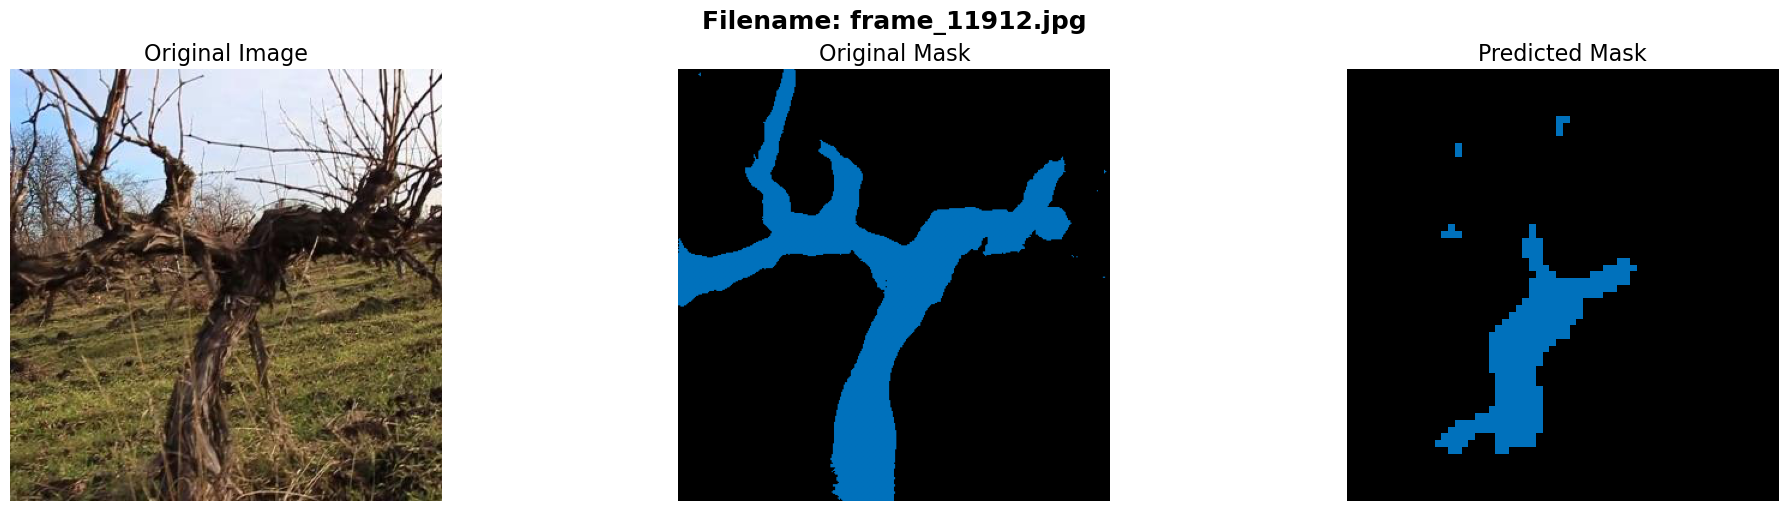

In [ ]:
# Randomly comparing validation/testing images, masks and predicted masks
rand_num = np.random.randint(len(test_dataset))
print(rand_num)
image, mask = test_dataset[rand_num]

rand_image_sample = test_dataset.image_list[rand_num] # Здесь надо получить еще и номер избражения в списке
rand_mask_sample = test_dataset.mask_list[rand_num]

plt.figure(figsize=(20, 5), layout='constrained')

plt.suptitle(f'Filename: {rand_image_sample}', fontweight='bold', fontsize=18)
plt.subplot(1, 3, 1)
image = plt.imread(os.path.join(test_dataset.dataset_dir, rand_image_sample))
plt.imshow(image)
plt.title('Original Image', fontsize=16)
plt.axis(False)


plt.subplot(1, 3, 2)
mask = plt.imread(os.path.join(test_dataset.dataset_dir, rand_mask_sample))
plt.imshow(mask)
plt.title('Original Mask', fontsize=16)
plt.axis(False)

plt.subplot(1, 3, 3)
#image = plt.imread()
plt.imshow(pred_result[rand_num])
plt.title('Predicted Mask', fontsize=16)
plt.axis(False);

The model performs fairly decent but there is still room for improvement. To further improve the performance the below mentioned steps can be

**Steps to improve the model performance:**
- Try running the model for more epochs
- Try using different model architectures
- Try using different encoder models
- Try using more efficient methods such as early stopping to prevent overfitting
- Try using differnt learning rate schedulers to reduce learning rate near convergence region.

**Consider giving an upvote👍 if you liked the notebook. It will help it to reach a wider audience.**

**It would be highly appreciated if you can take out some time to share your views on what you liked in the notebook and what can be the potential improvements that can be made to further improve the notebook.**

**Thanks**

# References

- **Notebook inspired from this project**: https://www.coursera.org/projects/deep-learning-with-pytorch-image-segmentation
- **Image Segmentation**: https://www.ibm.com/topics/image-segmentation
- **albumentations documentation**: https://albumentations.ai/docs/
- **segmentation_models_pytorch documentation**: https://smp.readthedocs.io/en/latest/
- **Unet++ original paper**: https://arxiv.org/abs/1807.10165
- **Dice Loss**: https://serp.ai/dice-loss/#:~:text=Dice%20Loss%20is%20an%20important,true%20segmentation%20of%20an%20image.